# Self-Driving Car Engineer Nanodegree

# Project: Vehicle Detection

# Submitted By: Ninad Ghike

In [1]:
# Imports

import matplotlib.image as mpimg
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

import glob
import random
import time

from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split

print('Imports Completed!')

Imports Completed!


# vehicles:  8792
# non vehicles:  8968


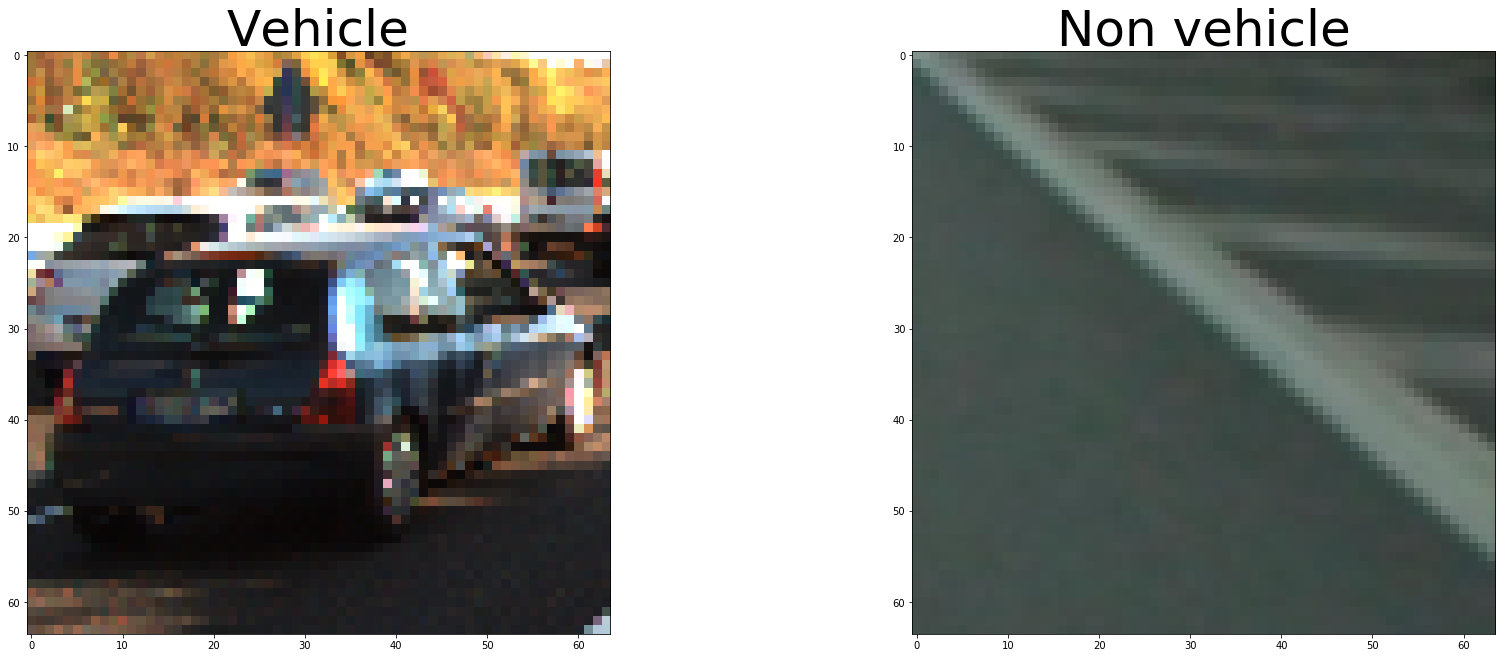

In [2]:
# Load training data files into memory

# Relative path to the vehicle and non vehicles image.
vehicle_pngs = []
non_vehicle_pngs = []
for image in glob.glob("./non-vehicles/non-vehicles/*/*.png"):
    non_vehicle_pngs.append(image)

for image in glob.glob("./vehicles/vehicles/*/*.png"):
    vehicle_pngs.append(image)

print('# vehicles: ', len(vehicle_pngs))
print('# non vehicles: ', len(non_vehicle_pngs))

rand_vehicle = random.choice(vehicle_pngs)
rand_non_vehicle = random.choice(non_vehicle_pngs)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mpimg.imread(rand_vehicle))
ax1.set_title('Vehicle', fontsize=50)
ax2.imshow(mpimg.imread(rand_non_vehicle))
ax2.set_title('Non vehicle', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [3]:
# Hog feature extraction

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

C:\Users\Ninad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


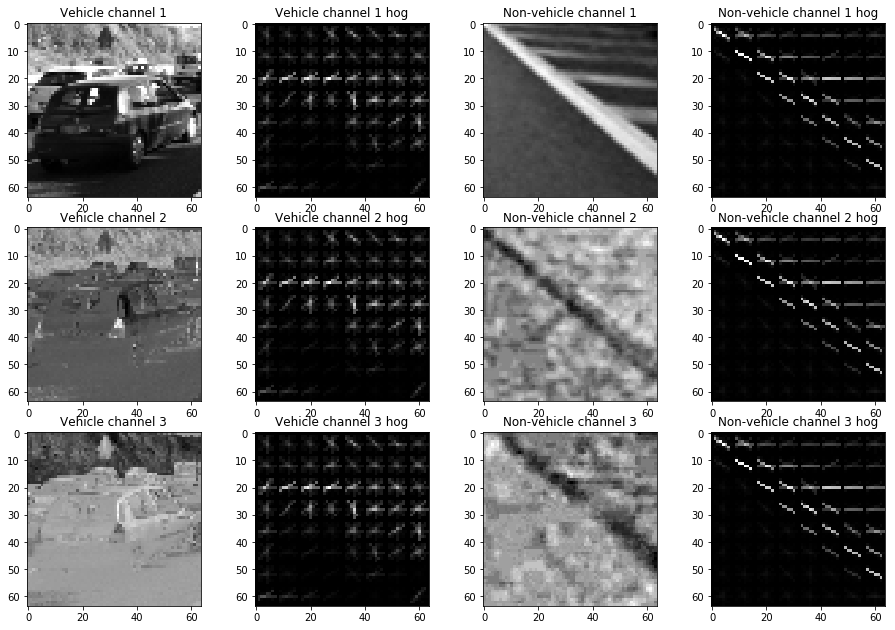

In [4]:
# Visualize hog features

def VisualizeHogFeature(vehicle_img, non_vehicle_img):
    v1_feature, v1_img = get_hog_features(
        vehicle_img[:,:,0], 8, 8, 2, vis=True, feature_vec=False)
    v2_feature, v2_img = get_hog_features(
        vehicle_img[:,:,1], 8, 8, 2, vis=True, feature_vec=False)
    v3_feature, v3_img = get_hog_features(
        vehicle_img[:,:,2], 8, 8, 2, vis=True, feature_vec=False)
    nv1_feature, nv1_img = get_hog_features(
        non_vehicle_img[:,:,0], 8, 8, 2, vis=True, feature_vec=False)
    nv2_feature, nv2_img = get_hog_features(
        non_vehicle_img[:,:,1], 8, 8, 2, vis=True, feature_vec=False)
    nv3_feature, nv3_img = get_hog_features(
        non_vehicle_img[:,:,2], 8, 8, 2, vis=True, feature_vec=False)

    fig = plt.figure()
    f, axis = plt.subplots(3, 4, figsize=(12, 9))
    f.tight_layout()
    for channel in range(3):
        axis[channel,0].imshow(vehicle_img[:,:,channel], cmap='gray')
        axis[channel,0].set_title('Vehicle channel %d'%(channel + 1), fontsize=12)
        axis[channel,1].imshow(v1_img, cmap='gray')
        axis[channel,1].set_title('Vehicle channel %d hog'%(channel + 1), fontsize=12)
        axis[channel,2].imshow(non_vehicle_img[:,:,channel], cmap='gray')
        axis[channel,2].set_title('Non-vehicle channel %d'%(channel + 1), fontsize=12)
        axis[channel,3].imshow(nv1_img, cmap='gray')
        axis[channel,3].set_title('Non-vehicle channel %d hog'%(channel + 1), fontsize=12)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

VisualizeHogFeature(
    cv2.cvtColor(mpimg.imread(rand_vehicle), cv2.COLOR_RGB2YCrCb),
    cv2.cvtColor(mpimg.imread(rand_non_vehicle), cv2.COLOR_RGB2YCrCb)
)

In [5]:
# Image feature extraction
 
def bin_spatial(img, size=(32, 32)):
    return cv2.resize(img, size).ravel() 

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                     hog_orient=8, hog_pix_per_cell=8, hog_cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(
                        get_hog_features(
                            feature_image[:,:,channel], 
                            hog_orient, hog_pix_per_cell, hog_cell_per_block, 
                            vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(
                    feature_image[:,:,hog_channel], hog_orient, 
                    hog_pix_per_cell, hog_cell_per_block,
                    vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return np.copy(features)

# Hyperparameters.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
    

vehicle_features = extract_features(
    vehicle_pngs, color_space=color_space, 
    spatial_size=spatial_size, hist_bins=hist_bins, 
    hog_orient=orient, hog_pix_per_cell=pix_per_cell, 
    hog_cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
non_vehicle_features = extract_features(
    non_vehicle_pngs, color_space=color_space, 
    spatial_size=spatial_size, hist_bins=hist_bins, 
    hog_orient=orient, hog_pix_per_cell=pix_per_cell, 
    hog_cell_per_block=cell_per_block, hog_channel=hog_channel,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)

print(vehicle_features.shape)

C:\Users\Ninad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(8792, 6108)


In [6]:
# Visualize feature vectors.

def VisualizeFeatures(v_feature, v_scaled_feature, nv_feature, nv_scaled_feature):
    fig = plt.figure()
    fig, axis = plt.subplots(2, 2, figsize=(12, 9))
    fig.suptitle('Feature vector', fontsize=24)
    axis[0, 0].plot(v_feature)
    axis[0, 0].set_yscale('log')
    axis[0, 0].set_title('Vehicle: Before normalizing')
    
    axis[0, 1].plot(v_scaled_feature)
    axis[0, 1].set_title('Vehicle: After StandardScaler')
    
    axis[1, 0].plot(nv_feature)
    axis[1, 0].set_yscale('log')
    axis[1, 0].set_title('Non-vehicle: Before normalizing')
    
    axis[1, 1].plot(nv_scaled_feature)
    axis[1, 1].set_title('Non-vehicle: After StandardScaler')

X shape:  (17760, 6108)
Y shape:  (17760,)


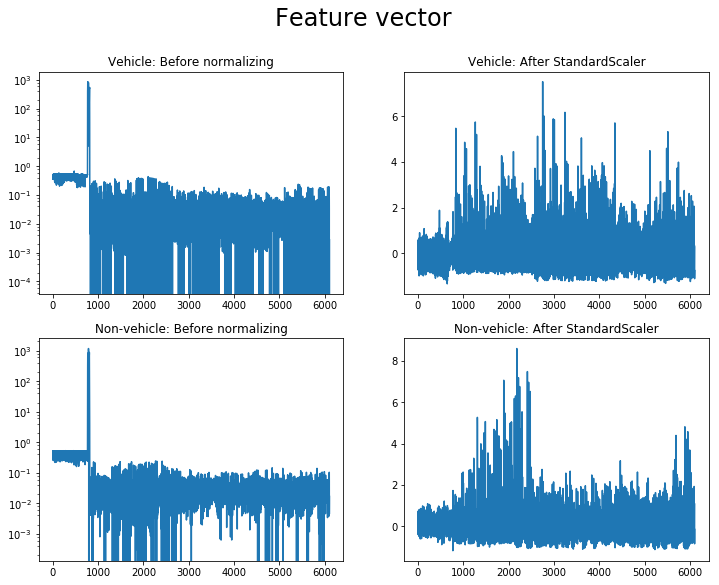

In [ ]:
# Prepare and normalize data

# Define the features.
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        

X_scaler = StandardScaler()
scaled_X = X_scaler.fit_transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Visualize feature vectors for vehicle vs non-vehicle
VisualizeFeatures(X[8], scaled_X[8], X[-36], scaled_X[-36])
# VisualizeFeatures(X[74], scaled_X[74], X[-1255], scaled_X[-1255])
# VisualizeFeatures(X[200], scaled_X[200], X[-332], scaled_X[-332])
print('X shape: ', X.shape)
print('Y shape: ', y.shape)

In [ ]:
# Train classifier.

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=123)

def PrintHyperparameterSetting():
    """Print a string about the hyperparameters"""
    print("===== Hyperparameter setting =====")
    print('Color space: %s'%color_space)
    if hog_feat:
        print('Hog: %d orientations, %d pixel per cell, %d cell per block, channel %s'
              %(orient,pix_per_cell,cell_per_block,str(hog_channel)))
    if spatial_feat:
        print('Spatial: size: ', spatial_size)
    if hist_feat:
        print('Histogram: %d bins'%hist_bins)
    print("===== End Hyperparameter setting =====")

PrintHyperparameterSetting()
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
start_time=time.time()
svc.fit(X_train, y_train)
end_time = time.time()

print(round(end_time - start_time, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

===== Hyperparameter setting =====
Color space: YCrCb
Hog: 9 orientations, 8 pixel per cell, 2 cell per block, channel ALL
Spatial: size:  (16, 16)
Histogram: 16 bins
===== End Hyperparameter setting =====
Feature vector length: 6108


In [ ]:
# Sliding window to do vehicle detection for an image.

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient=9,
              pix_per_cell=8, cell_per_block=2, spatial_size=(16,16), hist_bins=16):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    # Resize image according to scale.
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    # Use all 3 of the channels.
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # List of bounding boxes with vehicle detected.
    # Each element is a two-tuple corresponding to start and end (x, y).
    bboxes = []
    # Slides the windows through the image.
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                start_bbox = (xbox_left, ytop_draw+ystart)
                end_bbox = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                cv2.rectangle(draw_img,
                              start_bbox,
                              end_bbox,
                              (0,0,255),
                              6) 
                bboxes.append((start_bbox, end_bbox))
                
    return draw_img, bboxes

C:\Users\Ninad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


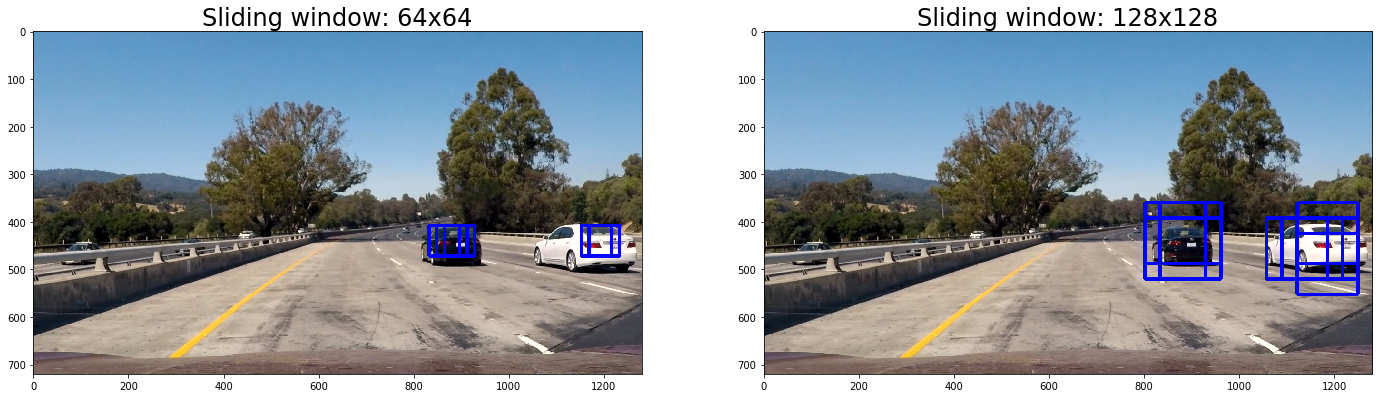

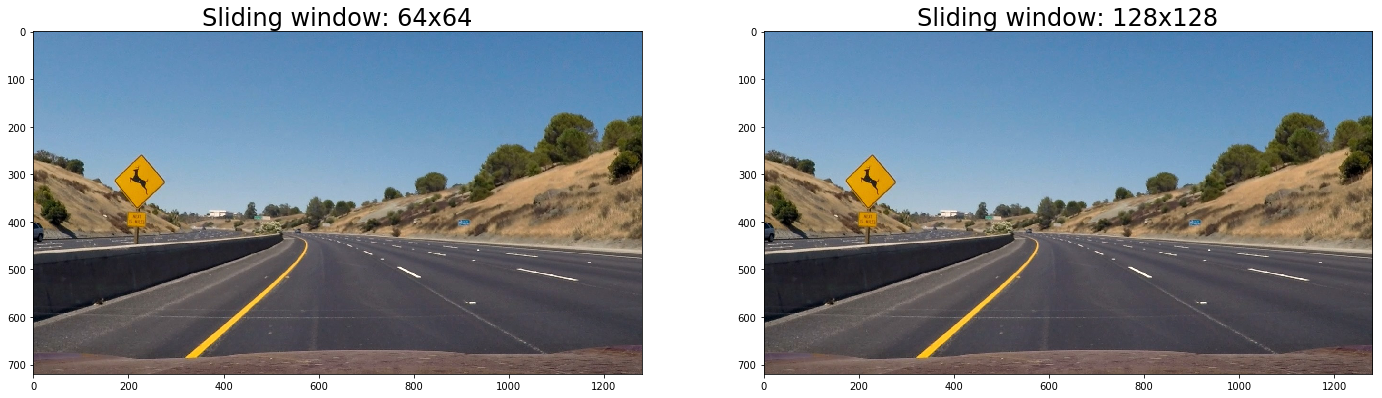

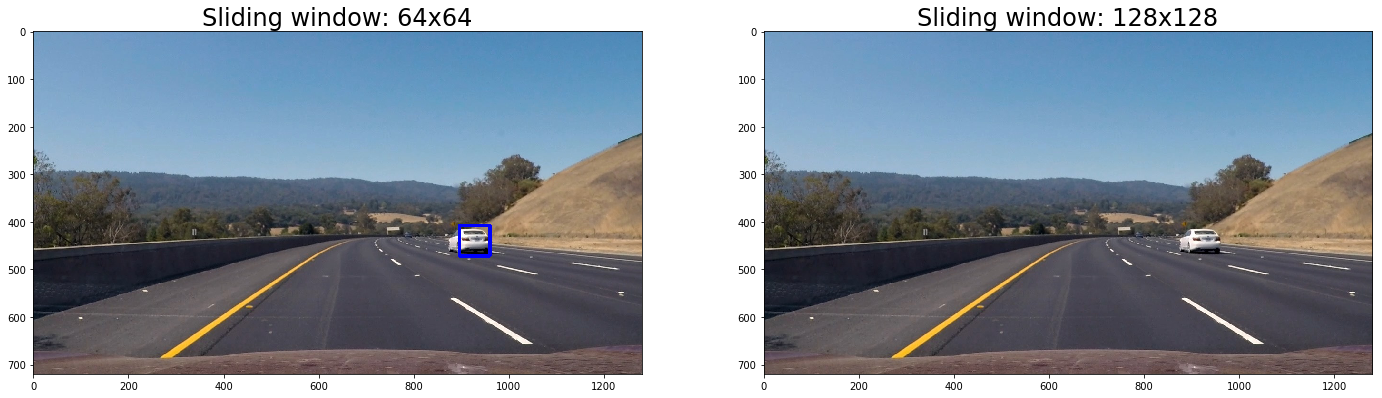

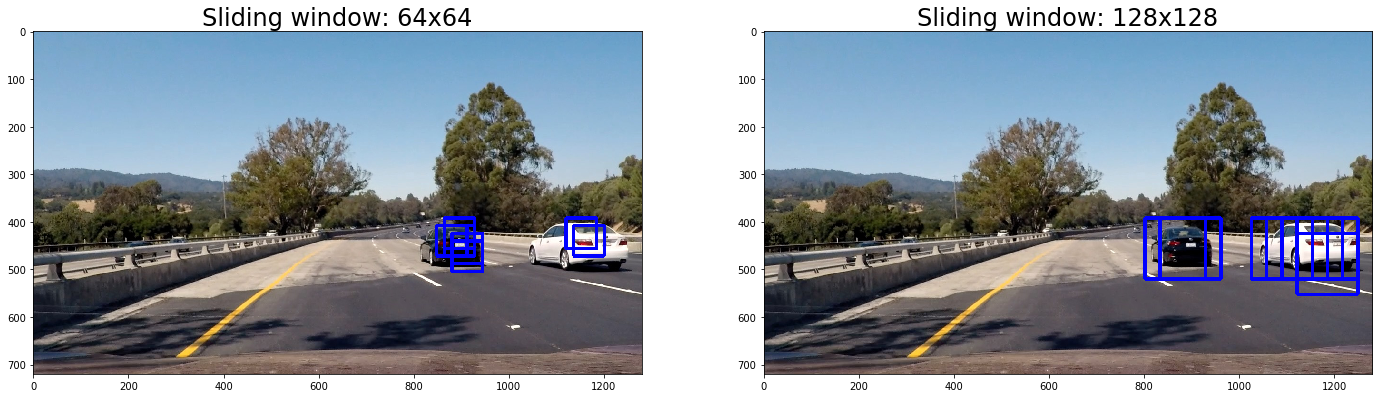

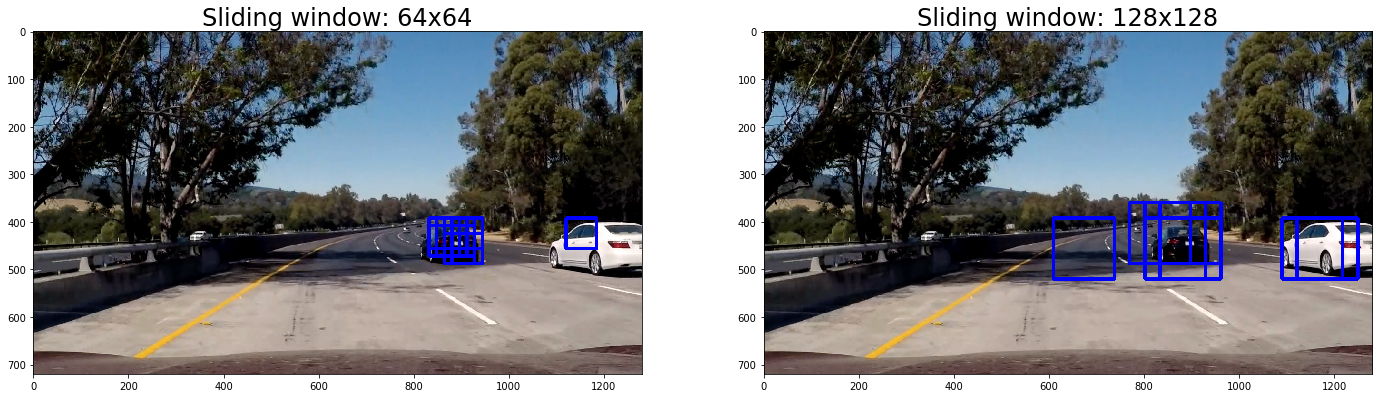

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [ ]:
# Test vehicle detection on test images using two different sliding window sizes.

for img in glob.glob("test_images/*.jpg"):
    image = mpimg.imread(img)
    fig = plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

    annotated_img, bboxes = find_cars(image, np.int(image.shape[0]/2), image.shape[0], 1, svc, X_scaler)
    ax1.imshow(annotated_img)
    ax1.set_title("Sliding window: 64x64", fontsize=24)

    annotated_img, bboxes = find_cars(image, np.int(image.shape[0]/2), image.shape[0], 2, svc, X_scaler)
    ax2.imshow(annotated_img)
    ax2.set_title("Sliding window: 128x128", fontsize=24)

In [ ]:
# Heatmap calculation to remove false positive

def add_heat(heatmap, bbox_list, is_remove=False):

    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1 if not is_remove else -1
    return heatmap

def apply_threshold(heatmap, threshold):
    """Threshold the heatmap to be 0 if <= threshold."""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected label
    bboxes = []
    for label in range(1, labels[1]+1):
        # Find pixels with each label value
        nonzero = (labels[0] == label).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)
    return img, bboxes

C:\Users\Ninad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


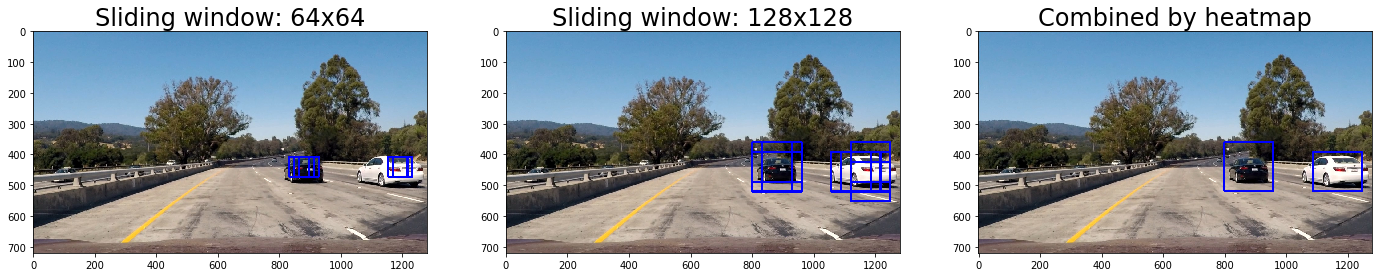

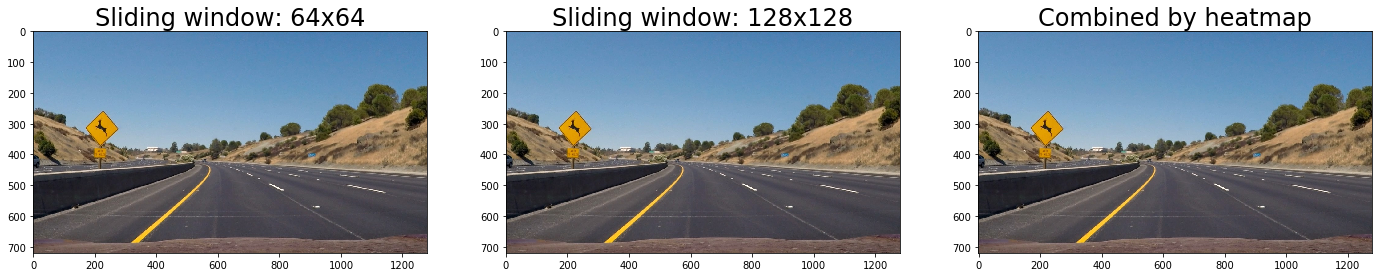

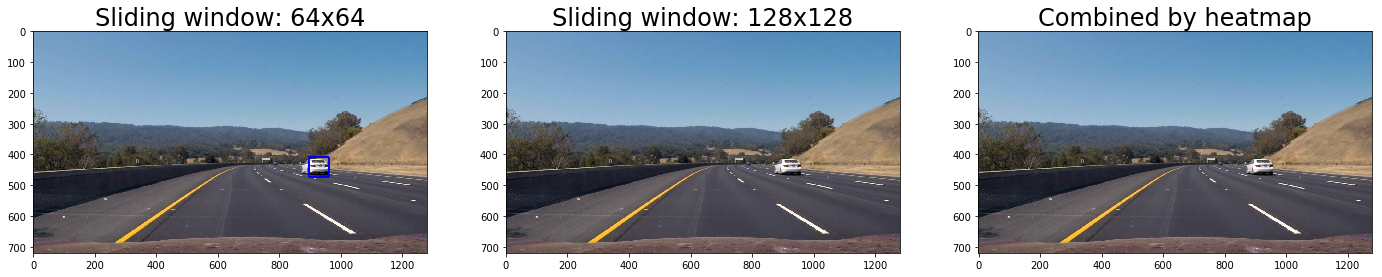

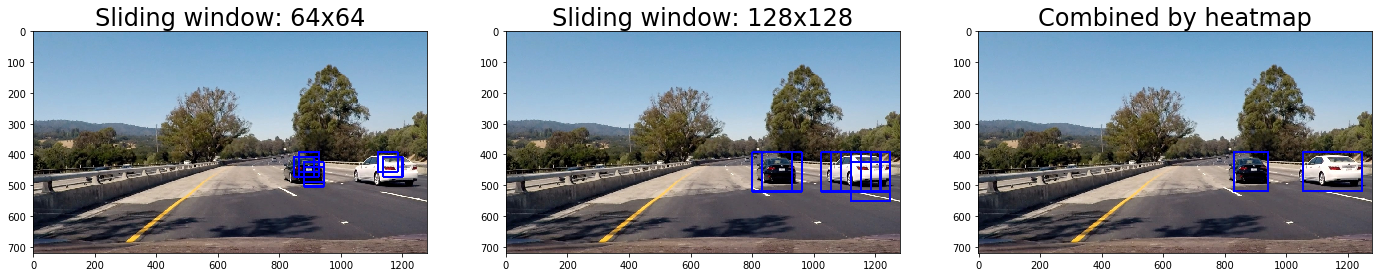

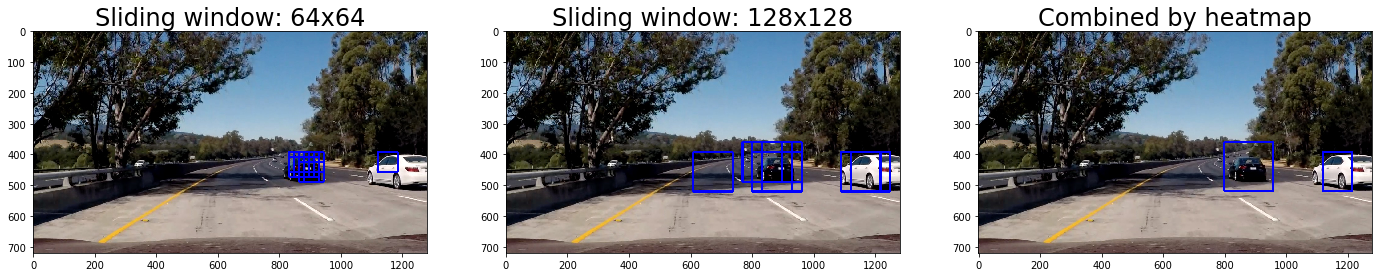

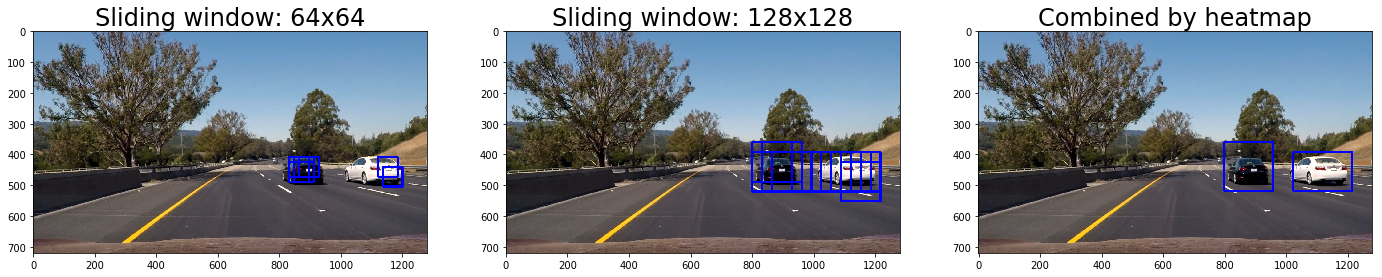

In [ ]:
# Visualize the effect of using heatmap to combine detection
# from two different sliding window size.

for img in glob.glob("test_images/*.jpg"):
    image = mpimg.imread(img)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    fig = plt.figure()
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    
    # 64 x 64 sliding window.
    annotated_img, bboxes = find_cars(image, np.int(image.shape[0]/2), image.shape[0], 1, svc, X_scaler)
    heat = add_heat(heat, bboxes)
    ax1.imshow(annotated_img)
    ax1.set_title("Sliding window: 64x64", fontsize=24)

    # 128 x 128 sliding window.
    annotated_img, bboxes = find_cars(image, np.int(image.shape[0]/2), image.shape[0], 2, svc, X_scaler)
    heat = add_heat(heat, bboxes)
    ax2.imshow(annotated_img)
    ax2.set_title("Sliding window: 128x128", fontsize=24)
    
    # Aggregate the heatmap.
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    combined_img, bboxes = draw_labeled_bboxes(np.copy(image), labels)
    ax3.imshow(combined_img)
    ax3.set_title("Combined by heatmap", fontsize=24)

In [ ]:
import queue
# We use a FIFO queue to keep track of the bounding boxes from previous frames
frames_bboxes = queue.Queue(7)
frames_heat = None

def DetectVehicle(image):
    """Detect vehicle in the image and draw bounding boxes around it.
    
    Note: This method will aggregate over multiple frames using global frames_bboxes and frames_heat.
    """
    # ============
    # First, aggregate the bboxes for this frame.
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # 64 x 64 sliding window.
    _, bboxes = find_cars(np.copy(image), np.int(image.shape[0]/2), image.shape[0], 1, svc, X_scaler)
    heat = add_heat(heat, bboxes)
    # 128 x 128 sliding window.
    _, bboxes = find_cars(np.copy(image), np.int(image.shape[0]/2), image.shape[0], 2, svc, X_scaler)
    heat = add_heat(heat, bboxes)
    
    # At least 2 bounding boxes to count as correct detection.
    heat = apply_threshold(heat, 1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    _, bboxes = draw_labeled_bboxes(np.copy(image), labels)
    
    
    # Next aggregate the bboxes across frames.
    global frames_heat
    global frames_bboxes
    if frames_heat is None:
        frames_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Remove the old frame from queue and heatmap if it is full.
    if frames_bboxes.full():
        old_bboxes = frames_bboxes.get()
        frames_heat = add_heat(frames_heat, old_bboxes, is_remove=True)

    # Add new frame.
    frames_bboxes.put(bboxes)
    frames_heat = add_heat(frames_heat, bboxes)

    # At least 4 frames should have the bbox to count.
    heat = apply_threshold(frames_heat.copy(), 3)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    final_image, _ = draw_labeled_bboxes(np.copy(image), labels)
    return final_image

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
    
output = 'output_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(DetectVehicle) #NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|███████████████████████████████████▉| 1260/1261 [1:08:36<00:03,  3.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

Wall time: 1h 8min 38s
